# Knowledge Distillation with Hint Training: Experiment 2

Depth Experiment, 3, 6, 9, 12 convolutional layers in student.


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

DeepNN(Not actually Deep): Shallow Neural Network but very wide with 3 Convolutional Layers and over 3 million parameters.
LightNN: much deeper network with 9 convolutional layers but much thinner with over 140,000 parameters.

In [24]:
# Wide Shallow neural network class to be used as teacher:
# 3 different instantiations where the hint layer parameters are returned, either first, second, or third convolutional layer

class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features2 = nn.Sequential(
            nn.Conv2d(128, 356, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3 = nn.Sequential(
            nn.Conv2d(356, 356, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(3204, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        conv_feature_map = x
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

In [25]:
#checking shape of data
for x, y in train_loader:
    print(x.shape)
    break

#checking shape of data
for x, y in test_loader:
    print(x.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


In [26]:
def train(model, train_loader, epochs, learning_rate, device, is_tuple):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            if is_tuple == True:
              outputs, map = model(inputs)
            if is_tuple == False:
              outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device, is_tuple):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if is_tuple == True:
              outputs, map = model(inputs)
            if is_tuple == False:
              outputs = model(inputs)

            #outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Train Teacher Network

In [27]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, epochs=15, learning_rate=0.001, device=device, is_tuple=True)
test_accuracy_deep = test(nn_deep, test_loader, device, is_tuple=True)

# Instantiate the lightweight network:
torch.manual_seed(42)

Epoch 1/15, Loss: 1.4520263959989523
Epoch 2/15, Loss: 0.9534348714382143
Epoch 3/15, Loss: 0.7547467898987138
Epoch 4/15, Loss: 0.6344018812527132
Epoch 5/15, Loss: 0.5438377241344403
Epoch 6/15, Loss: 0.4661091280257915
Epoch 7/15, Loss: 0.40139796339032596
Epoch 8/15, Loss: 0.3346936466443874
Epoch 9/15, Loss: 0.2862583933888799
Epoch 10/15, Loss: 0.24660988885652074
Epoch 11/15, Loss: 0.21071514782622036
Epoch 12/15, Loss: 0.17448605391223107
Epoch 13/15, Loss: 0.16270225264532182
Epoch 14/15, Loss: 0.13989289174489963
Epoch 15/15, Loss: 0.12728366112846243
Test Accuracy: 77.22%


In [28]:
sample_input = torch.randn(128, 3, 32, 32).to(device)

In [29]:
convolutional_fe_output_teacher = nn_deep.features1(sample_input)
# Print their shapes
#print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

Teacher's feature extractor output shape:  torch.Size([128, 128, 16, 16])


# Modified Networks: Teacher stays the same. Student requires convolutional regressor on top of the Guided Layer. This increases the number of parameters to over 294,000 parameters.

In [30]:
class LightNNRegressor4(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNNRegressor4, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output


class LightNNRegressor3(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNNRegressor3, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output




class LightNNRegressor2(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNNRegressor2, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output


class LightNNRegressor1(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNNRegressor1, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features3= nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
        )

        self.regressor = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(432, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features1(x)
        regressor_output = self.regressor(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output



In [31]:
mod_nn_light4 = LightNNRegressor4(num_classes=10).to(device)
mod_nn_light3 = LightNNRegressor3(num_classes=10).to(device)
mod_nn_light2 = LightNNRegressor2(num_classes=10).to(device)
mod_nn_light1 = LightNNRegressor1(num_classes=10).to(device)
convolutional_fe_output_student = mod_nn_light1.features1(sample_input)
convolutional_fe_output_teacher = nn_deep.features1(sample_input)
# Print their shapes
print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

Student's feature extractor output shape:  torch.Size([128, 16, 16, 16])
Teacher's feature extractor output shape:  torch.Size([128, 128, 16, 16])


In [32]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in mod_nn_light1.parameters()))
print(f"LightNN1 parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in mod_nn_light2.parameters()))
print(f"LightNN2 parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in mod_nn_light3.parameters()))
print(f"LightNN3 parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in mod_nn_light4.parameters()))
print(f"LightNN4 parameters: {total_params_light}")

DeepNN parameters: 3,201,122
LightNN1 parameters: 94,234
LightNN2 parameters: 126,586
LightNN3 parameters: 158,938
LightNN4 parameters: 191,290


In [33]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [34]:
import torch.nn as nn
import torch

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, inputs, targets):
        loss = (torch.norm(inputs - targets)**2)*0.5
        #loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        return loss.mean()

# Start 2-Stage Training:
1. MSE Loss between Hint and Guided Layers minimized for 10 epochs.
2. Knowledge distillation run where CE loss in combination with KD loss function are weighted and minimized.  

In [35]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    #mse_loss = CustomLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Again ignore teacher logits
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            # Forward pass with the student model
            student_logits, regressor_feature_map = student(inputs)

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Only minimize mse loss of teacher and regressor feature maps
            loss = 0.25 * hidden_rep_loss + 0.75 * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Notice how our test function remains the same here with the one we used in our previous case. We only care about the actual outputs because we measure accuracy.

# Initialize a ModifiedLightNNRegressor
torch.manual_seed(42)
modified_nn_light_reg = LightNNRegressor1(num_classes=10).to(device)
modified_nn_light_reg2 = LightNNRegressor2(num_classes=10).to(device)
modified_nn_light_reg3 = LightNNRegressor3(num_classes=10).to(device)
modified_nn_light_reg4 = LightNNRegressor4(num_classes=10).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep_reg = DeepNN(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())
modified_nn_deep_reg2 = DeepNN(num_classes=10).to(device)
modified_nn_deep_reg2.load_state_dict(nn_deep.state_dict())
modified_nn_deep_reg3 = DeepNN(num_classes=10).to(device)
modified_nn_deep_reg3.load_state_dict(nn_deep.state_dict())
modified_nn_deep_reg4 = DeepNN(num_classes=10).to(device)
modified_nn_deep_reg4.load_state_dict(nn_deep.state_dict())



#train(modified_nn_deep_reg, train_loader, epochs=10, learning_rate=0.001, device=device)
#test_accuracy_deep = test(modified_nn_deep_reg, test_loader, device)


#Freeze params after convolutional layers, train up until classifier
for param in modified_nn_light_reg.classifier.parameters():
  param.requires_grad = False
for param in modified_nn_light_reg2.classifier.parameters():
  param.requires_grad = False
for param in modified_nn_light_reg3.classifier.parameters():
  param.requires_grad = False
for param in modified_nn_light_reg4.classifier.parameters():
  param.requires_grad = False

# Train and test once again
train_mse_loss(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
train_mse_loss(teacher=modified_nn_deep_reg2, student=modified_nn_light_reg2, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
train_mse_loss(teacher=modified_nn_deep_reg3, student=modified_nn_light_reg3, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
train_mse_loss(teacher=modified_nn_deep_reg4, student=modified_nn_light_reg4, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)

Epoch 1/10, Loss: 1.4746694958118527
Epoch 2/10, Loss: 1.2946411944411296
Epoch 3/10, Loss: 1.201988443084385
Epoch 4/10, Loss: 1.140748247466124
Epoch 5/10, Loss: 1.095071877055156
Epoch 6/10, Loss: 1.059741404507776
Epoch 7/10, Loss: 1.0299462112014557
Epoch 8/10, Loss: 0.9978775151855196
Epoch 9/10, Loss: 0.9738185888970904
Epoch 10/10, Loss: 0.9545365385997021
Epoch 1/10, Loss: 1.466101734839437
Epoch 2/10, Loss: 1.2510292716038502
Epoch 3/10, Loss: 1.1537352742441476
Epoch 4/10, Loss: 1.0719080177109566
Epoch 5/10, Loss: 1.0093657601519923
Epoch 6/10, Loss: 0.9586536443751791
Epoch 7/10, Loss: 0.9154184890525116
Epoch 8/10, Loss: 0.866740804346626
Epoch 9/10, Loss: 0.832519513414339
Epoch 10/10, Loss: 0.805047000613054
Epoch 1/10, Loss: 1.4883876249308476
Epoch 2/10, Loss: 1.2383327179247765
Epoch 3/10, Loss: 1.0935420822304533
Epoch 4/10, Loss: 0.9977743640885024
Epoch 5/10, Loss: 0.9280431887987629
Epoch 6/10, Loss: 0.8772450482753842
Epoch 7/10, Loss: 0.8300635217095885
Epoch 8

In [36]:
#unfreeze parameters and train finally with knowledge distillation for stage 2

for param in modified_nn_light_reg.classifier.parameters():
  param.requires_grad = True
for param in modified_nn_light_reg2.classifier.parameters():
  param.requires_grad = True
for param in modified_nn_light_reg3.classifier.parameters():
  param.requires_grad = True
for param in modified_nn_light_reg4.classifier.parameters():
  param.requires_grad = True

def train_knowledge_distillation1(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits, _ = teacher(inputs)

            # Forward pass with the student model
            student_logits, _  = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")



In [37]:
train_knowledge_distillation1(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
train_knowledge_distillation1(teacher=modified_nn_deep_reg2, student=modified_nn_light_reg2, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
train_knowledge_distillation1(teacher=modified_nn_deep_reg3, student=modified_nn_light_reg3, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
train_knowledge_distillation1(teacher=modified_nn_deep_reg4, student=modified_nn_light_reg4, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)

Epoch 1/10, Loss: 2.055845944472896
Epoch 2/10, Loss: 1.8335507644716735
Epoch 3/10, Loss: 1.720101745537175
Epoch 4/10, Loss: 1.6413570118072394
Epoch 5/10, Loss: 1.5800259991375076
Epoch 6/10, Loss: 1.5146334299346065
Epoch 7/10, Loss: 1.4667835534381135
Epoch 8/10, Loss: 1.420478705250089
Epoch 9/10, Loss: 1.379581145618273
Epoch 10/10, Loss: 1.3473859129049588
Epoch 1/10, Loss: 1.8611842195701112
Epoch 2/10, Loss: 1.6552513093899583
Epoch 3/10, Loss: 1.5559272122809955
Epoch 4/10, Loss: 1.4756778692040602
Epoch 5/10, Loss: 1.408248235959836
Epoch 6/10, Loss: 1.3441572777755426
Epoch 7/10, Loss: 1.2910918977559376
Epoch 8/10, Loss: 1.2540225584793578
Epoch 9/10, Loss: 1.2058789716352283
Epoch 10/10, Loss: 1.1697957576693172
Epoch 1/10, Loss: 1.7665880939844625
Epoch 2/10, Loss: 1.6206640197188042
Epoch 3/10, Loss: 1.5447924719442188
Epoch 4/10, Loss: 1.4765410886701111
Epoch 5/10, Loss: 1.425373747068293
Epoch 6/10, Loss: 1.3724705804034572
Epoch 7/10, Loss: 1.316212609600838
Epoch 

In [38]:
print(f"Teacher Accuracy:")
test_accuracy_deep = test(modified_nn_deep_reg, test_loader, device, is_tuple= True)
print(f"Final Student Accuracy (3 Conv Layers):")
test_accuracy_light_ce_and_mse_loss1 = test_multiple_outputs(modified_nn_light_reg, test_loader, device)
print(f"Final Student Accuracy (6 Conv Layers):")
test_accuracy_light_ce_and_mse_loss2 = test_multiple_outputs(modified_nn_light_reg2, test_loader, device)
print(f"Final Student Accuracy (9 Conv Layers):")
test_accuracy_light_ce_and_mse_loss3 = test_multiple_outputs(modified_nn_light_reg3, test_loader, device)
print(f"Final Student Accuracy (12 Conv Layers):")
test_accuracy_light_ce_and_mse_loss4 = test_multiple_outputs(modified_nn_light_reg4, test_loader, device)

Teacher Accuracy:
Test Accuracy: 77.22%
Final Student Accuracy (3 Conv Layers):
Test Accuracy: 71.28%
Final Student Accuracy (6 Conv Layers):
Test Accuracy: 74.45%
Final Student Accuracy (9 Conv Layers):
Test Accuracy: 73.68%
Final Student Accuracy (12 Conv Layers):
Test Accuracy: 74.54%


In [39]:
#n_light = LightNN(num_classes=100).to(device)
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg.parameters()))
print(f"LightNN 3 conv layers parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg2.parameters()))
print(f"LightNN 6 conv layers parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg3.parameters()))
print(f"LightNN 9 conv layers parameters: {total_params_light}")
total_params_light = "{:,}".format(sum(p.numel() for p in modified_nn_light_reg4.parameters()))
print(f"LightNN 12 conv layers parameters: {total_params_light}")

DeepNN parameters: 3,201,122
LightNN 3 conv layers parameters: 94,234
LightNN 6 conv layers parameters: 126,586
LightNN 9 conv layers parameters: 158,938
LightNN 12 conv layers parameters: 191,290


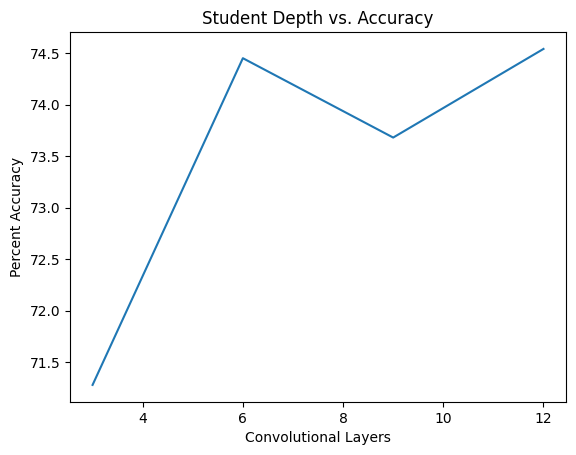

In [40]:
import matplotlib.pyplot as plt

# x axis values
x = [3,6,9,12]
# corresponding y axis values
y = [test_accuracy_light_ce_and_mse_loss1,test_accuracy_light_ce_and_mse_loss2,test_accuracy_light_ce_and_mse_loss3,test_accuracy_light_ce_and_mse_loss4]

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('Convolutional Layers')
# naming the y axis
plt.ylabel('Percent Accuracy')

# giving a title to my graph
plt.title('Student Depth vs. Accuracy')

# function to show the plot
plt.show()